In [1]:
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import argparse
import ast
import random
import matplotlib.pyplot as plt

from torch.distributions import MultivariateNormal
from IPython.display import clear_output
import scipy.ndimage as ndimage
import os
import cv2
from torch.utils.data import DataLoader, Dataset
import metrics
import joblib
import copy
from torchvision import transforms
from enum import Enum
import faiss

from dataloaders import dataloader_MVTec_setup
from utils import get_files_masks, evaluate
from evaluate import evaluate_metrics, get_scores, load_model, visualize_result
from DQN import DQN
from environment import Environment

In [2]:
def parse_tuple(value):
    try:
        return ast.literal_eval(value)
    except (ValueError, SyntaxError):
        raise argparse.ArgumentTypeError(f"Invalid tuple: {value}")
parser = argparse.ArgumentParser()
# ------------ 
# setup
# ------------
parser.add_argument("--use_gpu", action="store_true", help="Use GPU for training")
#parser.add_argument("--data_root", type=str, default= "./../../../../scratch-beauty/zzhan762/data/MVTec_AD")
#parser.add_argument("--data_root", type=str, default= "./mvtec")
parser.add_argument("--data_root", type=str, default= "./data/mvtec")
parser.add_argument("--verbose", type=bool, default=True)
# ------------------ 
# feature extractor
# ------------------
parser.add_argument("--target_size", type=parse_tuple, default="(224,224)")
parser.add_argument("--resize_size", type=parse_tuple, default="(224,224)")
parser.add_argument("--class_name", type=str, default="toothbrush")
parser.add_argument("--batch_size", type=int, default=8)
parser.add_argument("--patch_size",type=int, default=3)
parser.add_argument("--target_embed_dimension", type=int, default=1024)
parser.add_argument("--edc", action="store_true")
parser.add_argument("--backbone", type=str,default="wide_resnet50_2")
parser.add_argument("--preprocessing_dimension", type=int, default=1024)

# ------------
# DQN 
# ------------
parser.add_argument("--action_dim", type=int, default=2)
parser.add_argument("--max_steps",type=int, default=int(4e4))
parser.add_argument("--eval_interval", type=int, default =int(1e3))
parser.add_argument("--lr",type=float,default = 0.00025)
parser.add_argument("--epsilon",type=float,default=1.0)
parser.add_argument("--epsilon_min",type=float,default=0.1)
parser.add_argument("--gamma", type=float, default=0.99)
parser.add_argument("--dqn_batch_size",type=int,default=32)
parser.add_argument("--warmup_steps",type=int, default=int(2e3))
parser.add_argument("--buffer_size",type=int,default=int(5e3))
parser.add_argument("--target_update_interval",type=int,default=int(5e3))

# ---------------
# Envirnment
# ---------------
parser.add_argument("--prob", type=float, default=0.5)
parser.add_argument("--max_samples",type=float,default=40)
parser.add_argument("--iForest_update_interval",type=int,default=int(2e3))
parser.add_argument("--iForest_max_samples",type=float,default=0.3)
parser.add_argument("--iForest_total_samples",type=int,default=int(1e6))
parser.add_argument("--iForest_batch_size",type=int,default=1024)


# -----------------------
# components
# -----------------------
parser.add_argument("--use_prioritized", type=bool, default=False)
parser.add_argument("--use_intrinsic",type=bool, default=False)
parser.add_argument("--use_copypaste", type=bool, default=False)
parser.add_argument("--use_faiss", type=bool, default=False)


args = parser.parse_args(['--use_gpu'])

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() and args.use_gpu else "cpu")
print('device: {}'.format(device))
args.backbone = 'wide_resnet50_2'
args.layers = ['layer2','layer3']
args.hidden_sizes = [512,256,128]
args.state_dim = args.target_embed_dimension

device: cuda


zipper


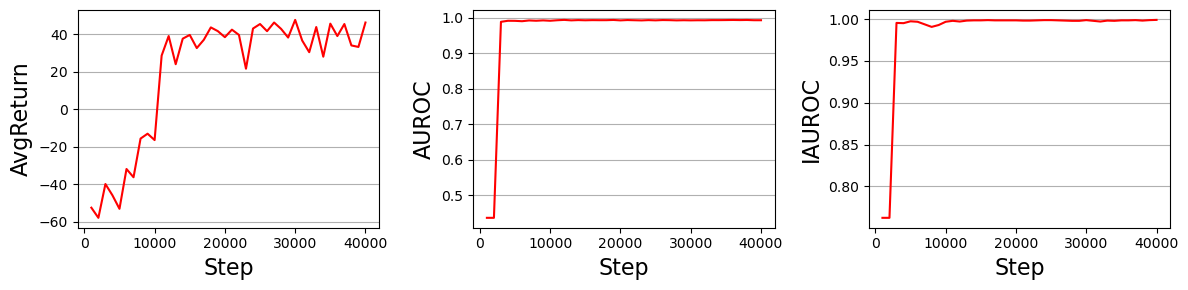

In [4]:
#classes = [item for item in os.listdir(args.data_root) if not item.endswith('.txt')]
#classes = ["bottle","cable","capsule","carpet","grid","hazelnut","leather","metal_nut","pill","screw","tile","toothbrush","transistor","wood","zipper"]
classes = ["capsule","carpet","grid","hazelnut","leather","metal_nut","pill","screw","tile","toothbrush","transistor","wood","zipper"]

#assert (len(classes) == 15)
for class_name in classes:
    torch.cuda.empty_cache()
    args.class_name = class_name
    target_types = [item for item in os.listdir(os.path.join(args.data_root, args.class_name,'test')) if item != 'good']
    unknown_types = []
    files_dict = get_files_masks(args.data_root,args.class_name,target_types,unknown_types,1,verbose=True)
    agent = DQN(args,device=device)
    env = Environment(files_dict['train_normal_files'],
                    files_dict['train_target_files'],
                    files_dict['train_target_masks'],args,device)
    env.update_subsamples(agent.network)
    #env.initialize(agent.network)
    eval_env = Environment(files_dict['train_normal_files'],
                        files_dict['train_target_files'],
                        files_dict['train_target_masks'],args,device,eval=True)
    eval_env.update_subsamples(agent.network)
    history = {'Step':[],'AvgReturn':[],'auroc':[],'i_auroc':[]}
    s = env.reset()
    best_result = 0
    while True:
        action = agent.act(s)
        next_state, reward, terminated, truncated, info = env.step(agent.network,action)
        result = agent.process((s, action, reward, next_state, terminated))
        s = next_state
        if terminated or truncated:
            s = env.reset()
        if agent.total_steps % args.eval_interval == 0:
            #eval_env.copy_from_env(env)
            ret = evaluate(eval_env,agent)
            checkpoint = {
                'model': agent.network.state_dict(),
                'args': args
            }
            checkpoint_path = os.path.join('checkpoints/mvtec_1_None','dqn_'+class_name +'_1.pt')
            torch.save(checkpoint,checkpoint_path)
            scores_dict = get_scores(checkpoint_path,device)
            norm_scores = (scores_dict['total_scores']-scores_dict['total_scores'].min())/(scores_dict['total_scores'].max()-(scores_dict['total_scores'].min()))
            result = evaluate_metrics(scores_dict['total_labels'],norm_scores)
            cur_res = (result['auroc'] + result['i_auroc'])/2
            if cur_res >= best_result:
                best_result=cur_res
                torch.save(checkpoint,os.path.join('checkpoints/mvtec_1_None','dqn_'+class_name +'_1_best.pt'))
            history['Step'].append(agent.total_steps)
            history['AvgReturn'].append(ret)
            history['auroc'].append(result['auroc'])
            history['i_auroc'].append(result['i_auroc'])
            clear_output()
            print(class_name)
            fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,3))
            ax1.plot(history['Step'],history['AvgReturn'],'r-')
            ax1.set_xlabel('Step',fontsize=16)
            ax1.set_ylabel('AvgReturn', fontsize=16)
            ax1.grid(axis='y')
            ax2.plot(history['Step'],history['auroc'],'r-')
            ax2.set_xlabel('Step',fontsize=16)
            ax2.set_ylabel('AUROC', fontsize=16)
            ax2.grid(axis='y')
            ax3.plot(history['Step'],history['i_auroc'],'r-')
            ax3.set_xlabel('Step',fontsize=16)
            ax3.set_ylabel('IAUROC', fontsize=16)
            ax3.grid(axis='y')
            plt.tight_layout()
            plt.savefig(os.path.join('checkpoints/mvtec_1_None','dqn_'+class_name +'_1.png'))
            plt.show()
        if agent.total_steps > args.max_steps:
            break

In [5]:
classes = [item for item in os.listdir(args.data_root) if not item.endswith('.txt')]
#classes = ["toothbrush"]
assert (len(classes) == 15)
IAUROC = 0
PAUROC = 0
for class_name in classes:
    print(class_name)
    checkpoint_path = './checkpoints/mvtec_1_None/dqn_'+class_name + '_1_best.pt'
    scores_dict = get_scores(checkpoint_path,device)
    norm_scores = (scores_dict['total_scores']-scores_dict['total_scores'].min())/(scores_dict['total_scores'].max()-(scores_dict['total_scores'].min()))
    result = evaluate_metrics(scores_dict['total_labels'],norm_scores)
    PAUROC += result['auroc']
    IAUROC += result['i_auroc']
print(PAUROC/15)
print(IAUROC/15)

bottle
torch.Size([1, 512, 28, 28])
torch.Size([1, 1024, 14, 14])
auroc: 0.9455187293072828
auprc: 0.7220312256114025
aupro: 0.25071411471797683
thres: 6.70050752660245e-08
image_thres: 0.0014340680791065097
i_auroc: 1.0
i_auprc: 1.0
f1: 1.0
accuracy: 1.0
cable
torch.Size([1, 512, 28, 28])
torch.Size([1, 1024, 14, 14])
auroc: 0.9229662672973629
auprc: 0.6930691610508373
aupro: 0.2986127123656046
thres: 0.002441616263240576
image_thres: 0.018151987344026566
i_auroc: 0.9330870279146142
i_auprc: 0.9620126759814662
f1: 0.8969696969696969
accuracy: 0.8802816901408451
capsule
torch.Size([1, 512, 28, 28])
torch.Size([1, 1024, 14, 14])
auroc: 0.9183042497675674
auprc: 0.3890447079648425
aupro: 0.1822158051631523
thres: 0.000990689150057733
image_thres: 0.0023152921348810196
i_auroc: 0.919314381270903
i_auprc: 0.9832070924437772
f1: 0.927536231884058
accuracy: 0.8818897637795275
carpet
torch.Size([1, 512, 28, 28])
torch.Size([1, 1024, 14, 14])
auroc: 0.9928491360433234
auprc: 0.8132672755660415

In [ ]:
checkpoint_path = './checkpoints/final_1/dqn_zipper_10_best.pt'
scores_dict = get_scores(checkpoint_path,device)
norm_scores = (scores_dict['total_scores']-scores_dict['total_scores'].min())/(scores_dict['total_scores'].max()-(scores_dict['total_scores'].min()))

evaluate_metrics(scores_dict['total_labels'],norm_scores)
visualize_result(8,scores_dict['total_imgs'],scores_dict['total_labels'],norm_scores)

FileNotFoundError: [Errno 2] No such file or directory: './checkpoints/final_1/dqn_zipper_10_best.pt'